In [1]:
#libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import folium
import warnings
from shapely.geometry import Point
from base64 import b64encode
from os import path, listdir, remove

#settings
%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set(style='white')
#plt.style.use('seaborn')
#plt.style.available

## Methodes

In [2]:
def plot_locatie_stof(loclijst, stoflijst, data):
    fig, ax = plt.subplots(1, figsize=(30,15))
    
    for s in stoflijst:
        stof_df = data.loc[data['PAR'] == s]
        ehd = stof_df[['EHD']].iloc[1][0]
        for l in loclijst:
            lijn = stof_df.loc[stof_df['LOCOMS'] == l]
            roll = lijn[['DATUM:TIJD', 'WAARDE']].set_index('DATUM:TIJD').rolling('365D').mean()
            if len(lijn) > 0:
                graph1 = lijn.plot('DATUM:TIJD', 'WAARDE', ax = ax, c='r', label = l+' '+s+' '+ehd, alpha=0.4)
                graph2 = roll.plot(ax=ax, c='black', linestyle='-', label = '_nolegend_')
            else:
                print(l + ' (' + s + ') : data niet aanwezig')
    
    plt.legend([l+' '+s+' '+ehd, 'Moving average (365 days)'], frameon=False, loc='upper center', ncol=2, fontsize=25)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel('')
    plt.ylabel('Waarde (' + ehd + ')', fontsize=30)
    plt.title('Gemeten waardes per stof per locatie + moving average\n', fontsize=30)
    plt.grid(True, axis='y')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.tight_layout()
    plt.savefig('img/plot_locstof_' + l + '_'+ s +'.jpg')
    plt.show()

In [3]:
def plot_mean_hilo(dataframe, par, sortby):
    par_data = dataframe.loc[ dataframe['PAR'] == par].groupby('LOCOMS')['WAARDE'].agg({'Min':'min','Max':'max','Mean':'mean'})
    ehd = dataframe[['EHD']].loc[df.PAR == par].iloc[1][0]
    if len(par_data > 0):
        par_data.sort_values(by = sortby).plot(kind = 'barh', figsize = (25,25), title = 'Alle locaties (' + str(len(par_data)) + ') voor stof ' + par + ' ' + ehd)
        plt.xlabel(ehd, fontsize=20)
        plt.show()
    else:
        print('data niet aanwezig')

In [4]:
def map_mean_stof(stof, df, loclijst, aggfunc = 'mean', circlesize = 1, output = False):
    locs= df.loc[df.LOCOMS.isin(loclijst)]
    locoms = locs[['LOCOMS', 'X_RD', 'Y_RD']].groupby('LOCOMS').max().dropna()
    geometry = [Point(xy) for xy in zip(locoms['X_RD'], locoms['Y_RD'])]
    geo_df = gpd.GeoDataFrame(geometry = geometry, index=locoms.index, crs = rd_crs).to_crs(epsg = '4326').reset_index()
    par_data = df.loc[ df['PAR'] == stof].groupby('LOCOMS')['WAARDE'].agg({'Agg': aggfunc}).reset_index()
    if(len(par_data > 0)):
        geo_df = geo_df.merge(par_data, on = 'LOCOMS')
        map_nl = folium.Map([52.11, 5.39], zoom_start=8, tiles = 'stamentoner')
        #map_nl.add_child(folium.LatLngPopup())
        for p in geo_df.itertuples():
            if path.exists('img/'+p[1]+'.jpg'):
                popup = folium.Popup(folium.IFrame('<img src="data:image/jpeg;base64,{}">'.format(b64encode(open('img/' + p[1]+'.jpg', 'rb').read()).decode()), width=500, height=400), max_width=500)
            else:
                popup = p[1] + ' (mean = ' + str(round(p[3],2)) + ')       ' + 'geen correlaties bekend'
            folium.CircleMarker(
                [p[2].y, p[2].x], 
                radius=p[3]*circlesize,
                popup=popup,
                fill_color='blue',
                fill_opacity=0.7,
                fill = True
            ).add_to(map_nl)
        if(output == True):
            map_nl.save('newpage.html')
            !newpage.html
        else:
            return map_nl
    else:
        print('stof heeft geen data')

In [5]:
def heatmap_corr_top10(top10_stof, df, par_list, graph=False):
    corrie = df.loc[df.PAR.isin(par_list)].pivot_table(index=['DATUM:TIJD', 'LOCOMS'], values='WAARDE', columns='PAR').corr(min_periods=100)
    if graph == True:
        fig, ax = plt.subplots(1, figsize = (25,25))
        sns.heatmap(corrie, cmap='jet', square=True, center = 0)
        plt.show()
    if corrie.columns.contains(top10_stof):
        return corrie[top10_stof].sort_values(ascending=False)
    else:
        print(top10_stof + ' niet in deze stad:')

In [6]:
def maak_grafieken(cr, loclijst, top=5, asc=False):
    remove_files('img', '.jpg')
    for i in loclijst:
        d = cr[i].sort_values(ascending=asc).iloc[:top].dropna()
        if d is not None:
            if not d.empty:
                fig, ax = plt.subplots(1, 1, figsize=(6,5))
                d.plot(kind='bar', ax=ax)
                plt.title('Top 10 correlaties stoffen in:\n'+ i + '\n', fontsize=17)
                plt.xticks(rotation=45, fontsize=16)
                plt.yticks(fontsize=16)
                if asc == False:
                    plt.ylim(0,1)
                else:
                    plt.ylim(-1,1)
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)
                plt.grid(True, axis='y')
                plt.tight_layout()
                fig.savefig('img/' + i + '.jpg')
                plt.close(fig)

In [7]:
def stof_locatie_corr_df(stof, loclijst, par_list,  df):
    output = pd.DataFrame()
    for l in loclijst:
        locatie_corr = heatmap_corr_top10(stof, df[df.LOCOMS == l], par_list)
        if locatie_corr is not None:
            locatie_corr.rename(l, inplace=True)
            output = pd.concat([output, locatie_corr], axis = 1)
        else:
            print(l)
    return output.drop(stof, axis=0)

In [8]:
def remove_files(mydir, extension):
    try:
        filelist = [ f for f in listdir(mydir) if f.endswith(extension) ]
        for f in filelist:
            remove(path.join(mydir, f))
    except:
        print('removing failed')

## Inlezen

In [9]:
def lookup(s):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.apply(lambda v: dates[v])

In [10]:
# read data
filename = '../../Project module 2/data/data_tot.csv'

columns = ['ID', 'DATUM', 'TIJD', 'LOCOMS','PAR', 'WAARDE',
           'EHD', 'BGC', 'KWC', 'HDH', 'ANA', 'CPM', 'BEM',
           'BTN', 'GBD', 'LOC:COORDSRT', 'LOC:X', 'LOC:Y',
           'OGI', 'ANI', 'BHI', 'BMI', 'VAT', 'STA:RKSSTATUS', 
           'X_RD', 'Y_RD', 'PAROMS']

omschrijvingen = ['ID', 'LOCOMS', 'ORGOMS', 'BTXCOD', 'BTXOMS',
                  'GBDOMS', 'OGIOMS', 'ANIOMS', 'BHIOMS',
                  'BMIOMS', 'VATOMS']

df = pd.read_csv(filename, encoding='latin1', usecols=columns, index_col='ID', engine='c')

df.insert(0, 'DATUM:TIJD', lookup(df.DATUM + df.TIJD))
df.drop(['DATUM', 'TIJD'], axis=1, inplace=True)

df['X_RD']= np.where(np.isnan(df['X_RD']), df['LOC:X']/100, df['X_RD'])
df['Y_RD']= np.where(np.isnan(df['Y_RD']), df['LOC:Y']/100, df['Y_RD'])

In [11]:
#relevante parameters > 5000 metingen
par_element = ['P', 'N', 'Cd', 'Pb', 'Ni', 'Zn', 'Cu', 'Cr', 'Fe', 'Mn', 'Co',
              'Ag', 'Ti', 'V', 'Sn', 'Tl', 'Mo', 'U', 'Te', 'Sb', 'Ba', 'Hg', 
              'Be', 'B', 'As', 'Rb', 'Li', 'O2', 'Sr', 'Al', 'Cs', 'Cl', 'KjN', 'Se', 
               'Ca', 'Na', 'Mg', 'K' ]

par_feature = ['T', 'pH', '%O2', 'SALNTT', 'WINDSHD', 'WINDRTG', 'ZICHT', 'GEUR', 'KLEUR',
               'AANTPVLME', 'E', 'GELDHD', 'HHTTL', 'LUCHTDK', 'NEERSVM', 'BEWKGD', 'OLE', 'SENSHTE',
               '%GR', 'GOLFHTE']

par_rest = ['ZS', 'DOC', 'NO3', 'NH4', 'PO4', 'NO2', 'SiO2', 'CHLFa', 'InP', 
                     'Ant', 'BghiPe', 'BkF', 'Flu', 'BbF', 'BaP', 'aHCH', 'cHCH', 
                     'bHCH', 'HCB', 'aedsfn', 'HxClbtDen', 'aldn', '44DDT', 'dieldn',
                     'Naf', '24DDT', 'idn', 'PeClBen', '44DDE', '44DDD', 'endn', 
                     'PCB52', 'PCB138', 'PCB180', 'PCB101', 'PCB118', 'PCB28', 'PCB153',
                     'Pyr', 'BaA', 'Chr', 'Fen', 'SO4', 'DBahAnt', 'TOC', 'HpCl', 'cHpClepO',
                     'TFySn', 'DFySn', 'TC4ySn', 'DC4ySn', 'tHpClepO', 'metlCl', 'T4C4ySn',
                     'pirmcb', 'alCl', 'iptrn', 'Durn', 'Cltlrn', 'tolcfsC1y', 'atzne', 'simzne',
                     'metbtazrn', 'linrn', 'Dmtat', 'dHCH', 'Clprfs', 'Tfrlne', 'PBDE100',
                     'PBDE47', 'PBDE153', 'PBDE99', 'PBDE154', 'PBDE28', 'Clfvfs', 'DClvs', 
                     'DEHP', 'terC4yazne', 's_NO3NO2', 'PBDE85', 'PBDE138', 'bedsfn', '123TClBen',
                     '124TClBen', '135TClBen', 'PBDE49', 'POC', 'PeClFol', '12DClBen', '14DClBen', 
                     '13DCLBen', '4ttC8yFol', 'HCO3', 'FEOa', '12DClC2a', 'Ben', 'TClC2e', 'TClC1a',
                     'TClC2e', 'T4ClC1a', 'DClC1a', 'HxClC2a', '112TClC2a', 'C2yBen', '111TClC2a', 
                     '12DClC3a', 'Daznn', 't12DClC2e', 'c12DClC2e', 'ClBen', 'etpfs', '1122T4ClC2a', 
                     'pyrazfs', 'malton', 'heptnfs', 'desC2yatzne', 'Tol', 'propzne', '2ClTol', 
                     '12xyln', 's_1314Xyl', 'cumn', 'Tazfs', 'fenton', 'ptonC1y', 's4C9yFol', 'feNO2ton',
                     'C2ypton', 'metzCl', 'coumfs', '11DClC2a', '3ClTol', 'mevfs', '11DClC2e', '3ClC3e',
                     'styrn', 'Clidzn', 'C2yazfs', 'Mlnrn', 'C1yazfs', 'GR', 'Clbmrn', 'monrn', 'metxrn',
                     'metbmrn', 'propcnzl', 'TFyPO4', 'TC4yPO4', 'Clxrn', 'terbtne' ]
allpars = par_element + par_feature + par_rest

In [12]:
#epsg:28992 (RD coord sys)
rd_crs = '+proj=sterea +lat_0=52.15616055555555 +lon_0=5.38763888888889 +k=0.999908 +x_0=155000 +y_0=463000 \
            +ellps=bessel +units=m +towgs84=565.2369,50.0087,465.658,-0.406857330322398,0.350732676542563,-1.8703473836068,4.0812 +no_defs '
nld = gpd.read_file('../data/shapefiles/water')

In [13]:
knmi_path = 'C:/Users/rwdev/Project module 2/data/knmi_data.txt'
knmi_df = pd.read_csv(knmi_path, header=97, skipinitialspace=True, parse_dates=['YYYYMMDD'])
knmi_df.drop(0, axis='index', inplace=True)
knmi_df['# STN'] = knmi_df['# STN'].astype('int64')
knmi_df.rename(columns={'# STN': 'STN'}, inplace=True)

C:\Users\rwdev\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [31]:
df[['PAR', 'PAROMS']].loc[df.PAR == 'TOC'].max()

PAR                             TOC
PAROMS    Totaal organisch koolstof
dtype: object

## Output

In [26]:
#df.LOCOMS.unique().tolist()
stof = 'ZS'

corr_df = stof_locatie_corr_df(stof, df.LOCOMS.unique().tolist() , allpars, df)

maak_grafieken(corr_df, loclijst=corr_df.columns, top=10, asc=False)

#map_mean_stof(stof, df, loclijst=corr_df.columns, aggfunc = 'mean', circlesize = 0.6, output=True)


ZS niet in deze stad:
Hollandsch Diep (mond Dordtsche Kil west)
ZS niet in deze stad:
Heusden Bernse Veer
ZS niet in deze stad:
Harlingen voorhaven


In [15]:
df[['DATUM:TIJD','LOCOMS', 'WAARDE', 'EHD']].loc[df.PAR=='ZS'].groupby(['LOCOMS'])['WAARDE'].agg(['count', 'mean', 'std', 'min', 'max']).nlargest(10, 'mean')

count        mean         std   min    max
LOCOMS                                                            
Groote Gat noord          211  178.317536  121.696117  39.0  732.0
Bocht van Watum noord      24  155.833333  173.086223  31.0  890.0
Bocht van Watum           184  119.627174   72.963933  25.2  490.0
Dantziggat                220  119.093636   58.401450  13.0  293.0
Ouddorp badstrand          12  110.166667  106.227743  21.0  374.0
Blauwe Slenk oost          45  101.288889   66.943878  23.0  337.0
Lauwersoog havenmond        7   99.285714   72.994781  18.0  200.0
Zuid Oost Lauwers oost     79   87.037975   51.433912   5.0  390.0
Schaar van Ouden Doel     284   83.603169   59.669627   6.8  620.0
Zoutkamperlaag             47   67.914894   39.799951  11.0  176.0

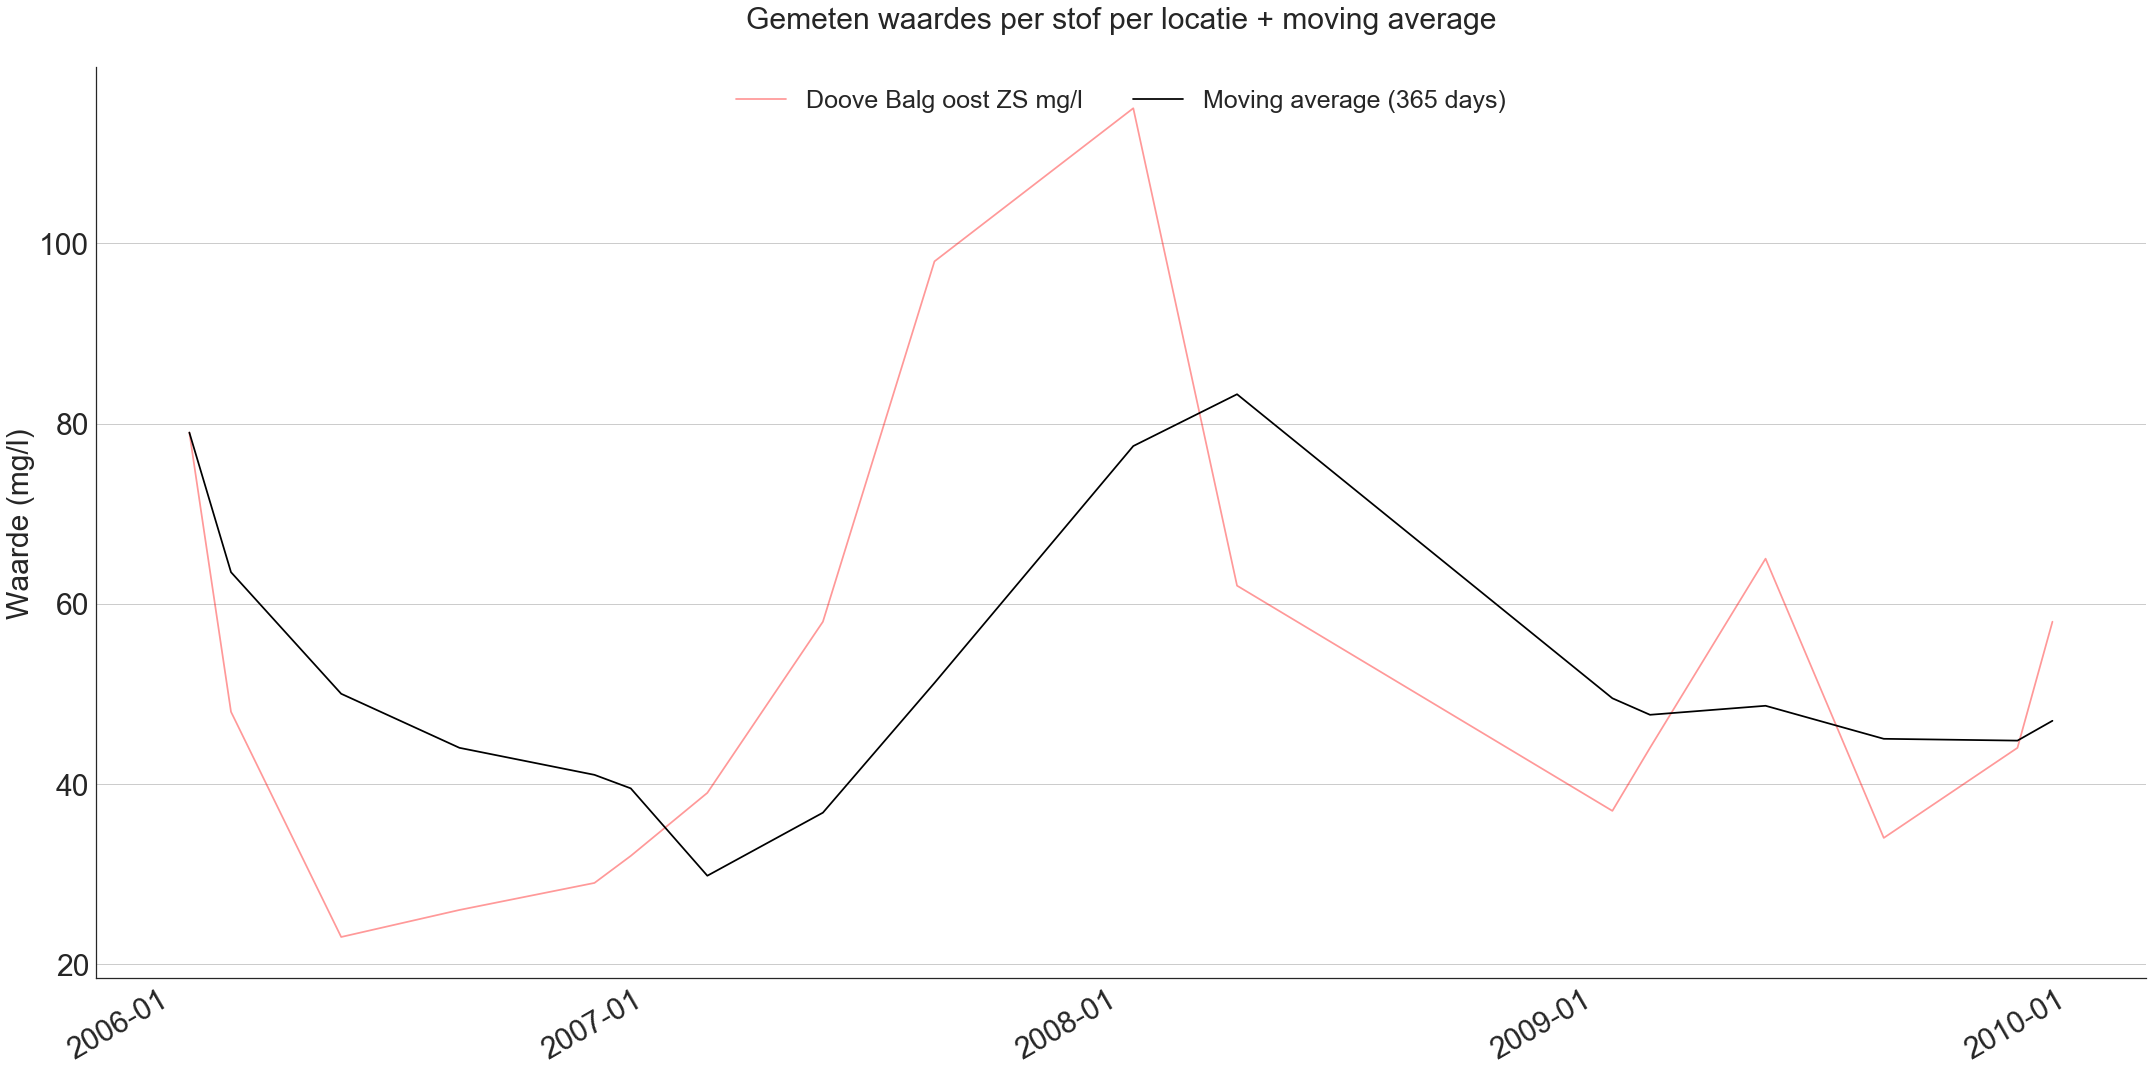

In [16]:
plot_locatie_stof(['Doove Balg oost'], ['ZS'], df)

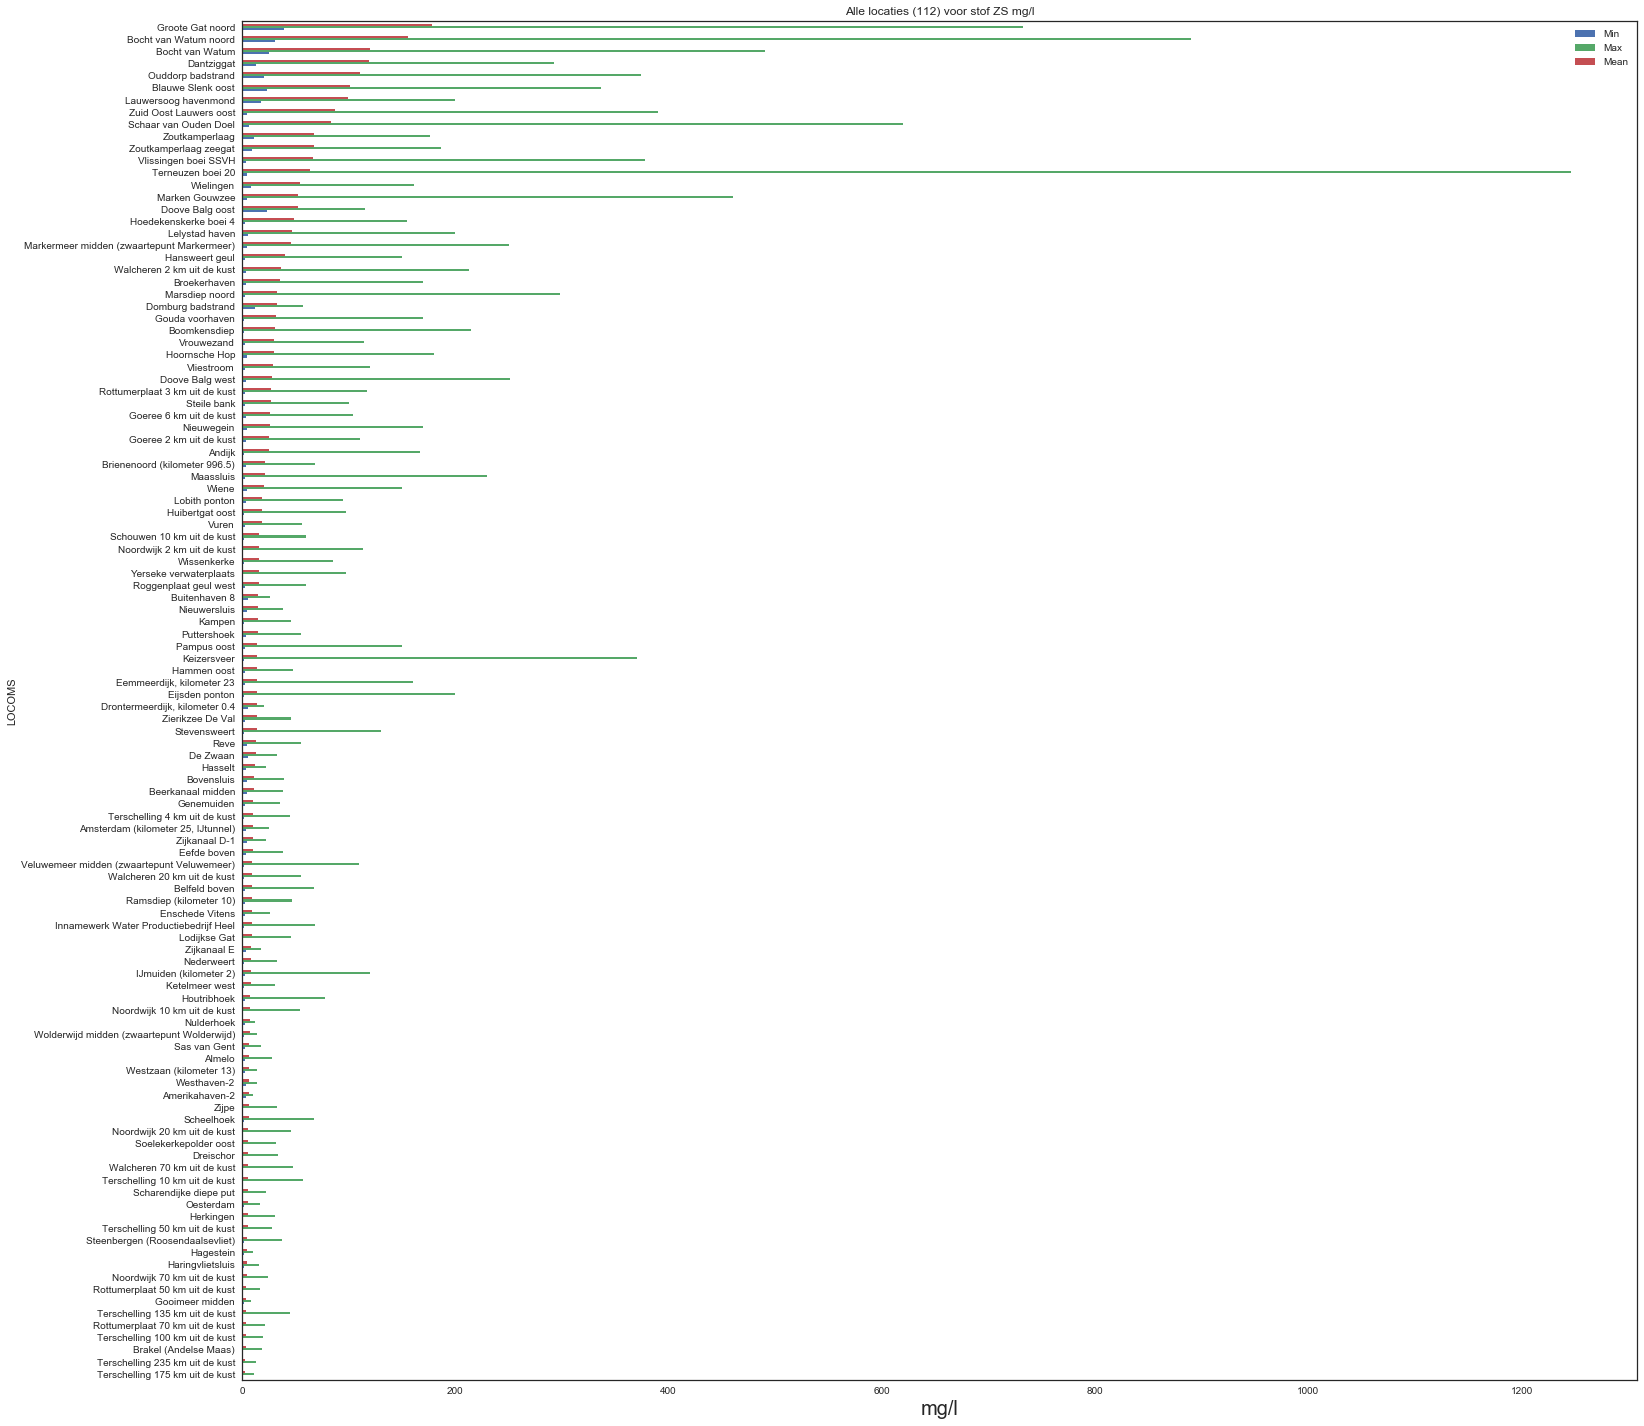

In [41]:
plot_mean_hilo(df, 'ZS', 'Mean')